Input data:
-	Artificial data as created by Cole

Exploratory:
-	Plot the data
-	Plot a Lomb-Scargle periodogram

Processing:
-	Compose a Gaussian Process from a reasonable guess of kernels
-	Learn the hyperparameters of each kernels by search
-	Substract the model from the data
-	Test that the remainder is white noise(?)
-	Predict gaps using the model?

Output:
-	Plot the data
-	Take X samples of final model and visualize
-	Show the model applied to the data with confidence intervals

Adapted in notebook 2:
- use linearily spaced test points

Changes compared to notebook cl_1:
- predict on evenly spaced points
- add maximum likelihood optimization

In [2]:
import math
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Use Celerite v2
import celerite2
from celerite2 import terms

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [4]:
df = pd.read_csv("../data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
# Print first and last lines of the dataset
#df.style.format('{:.16f}')
#df

In [6]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

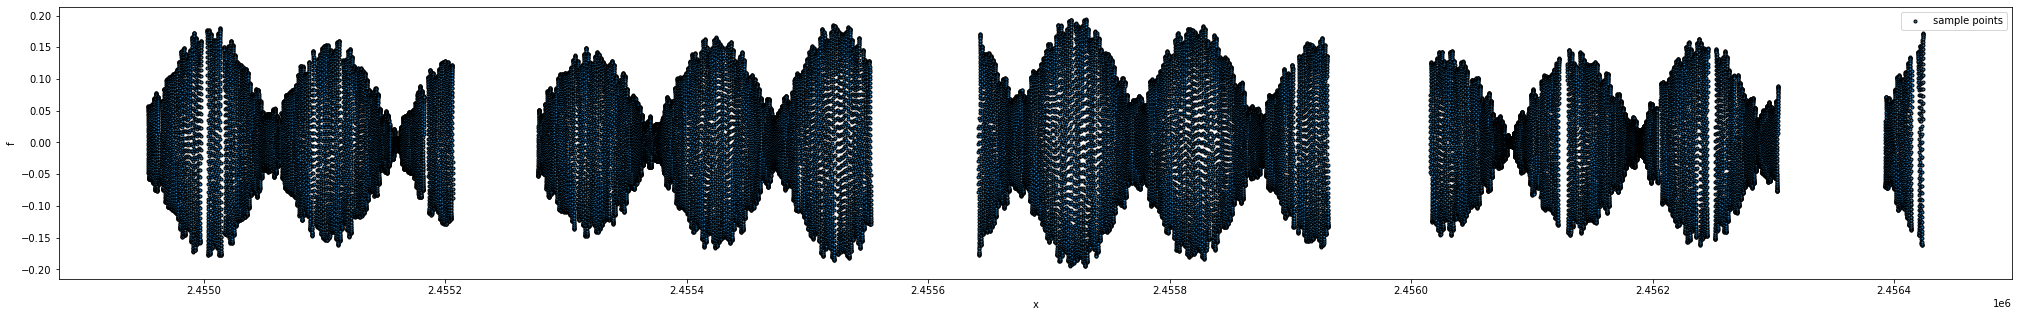

In [7]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

Zoomed in on the first N observations

In [8]:
N=int(X.shape[0]/4)
N

12993

In [9]:
train_x=X[:N]
train_y=Y[:N]

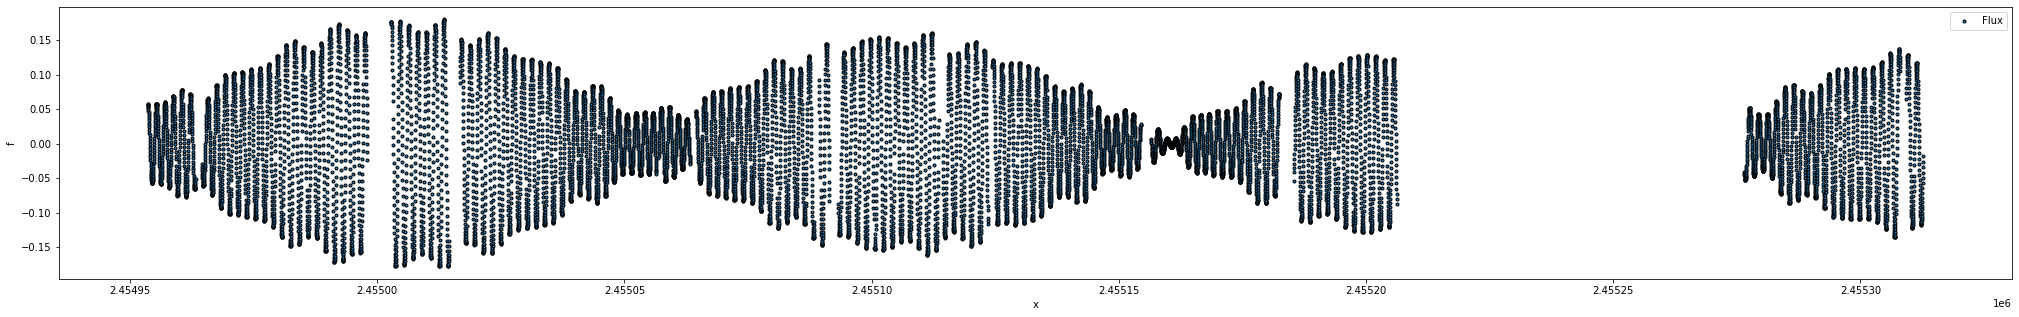

In [10]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(train_x, train_y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [12]:
# Quasi-periodic term
term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

# Non-periodic component
term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
kernel = term1 + term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(train_x, yerr=0)

print("Initial log likelihood: {0}".format(gp.log_likelihood(train_y)))

Initial log likelihood: 44261.25718098565


In [33]:
term1.Q, term1.S0, term1.w0

(31.41592653589793, 0.00506605918211689, 6.283185307179586)

Let’s look at the underlying power spectral density of this initial model:

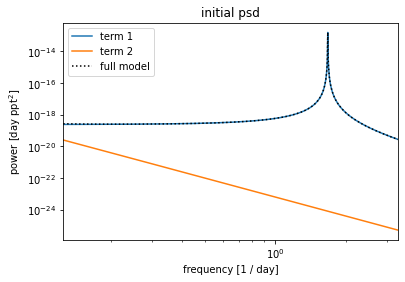

In [34]:
freq = np.linspace(1.0 / 8, 1.0 / 0.3, 500)
omega = 2 * np.pi * freq


def plot_psd(gp):
    for n, term in enumerate(gp.kernel.terms):
        plt.loglog(freq, term.get_psd(omega), label="term {0}".format(n + 1))
    plt.loglog(freq, gp.kernel.get_psd(omega), ":k", label="full model")
    plt.xlim(freq.min(), freq.max())
    plt.legend()
    plt.xlabel("frequency [1 / day]")
    plt.ylabel("power [day ppt$^2$]")


plt.title("initial psd")
plot_psd(gp)

In [35]:
# Predict evenly spaced points on our time-axis
test_x = np.linspace(train_x.min(),train_x.max(),N)

In [20]:
pred_y, variance = gp.predict(train_y, t=test_x, return_var=True)

In [21]:
def plot_prediction(mu, variance):
    plt.plot(train_x, train_y, ".", mew=1, linewidth=1, mec="black")
#    plt.plot(train_x, train_y, "k", lw=1.5, alpha=0.8, label="data")
#    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    sigma = np.sqrt(variance)

    plt.plot(test_x, mu, label="prediction")
    plt.fill_between(test_x, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
#    plt.xlim(0, 10)
#    plt.ylim(-2.5, 2.5)
    plt.legend()

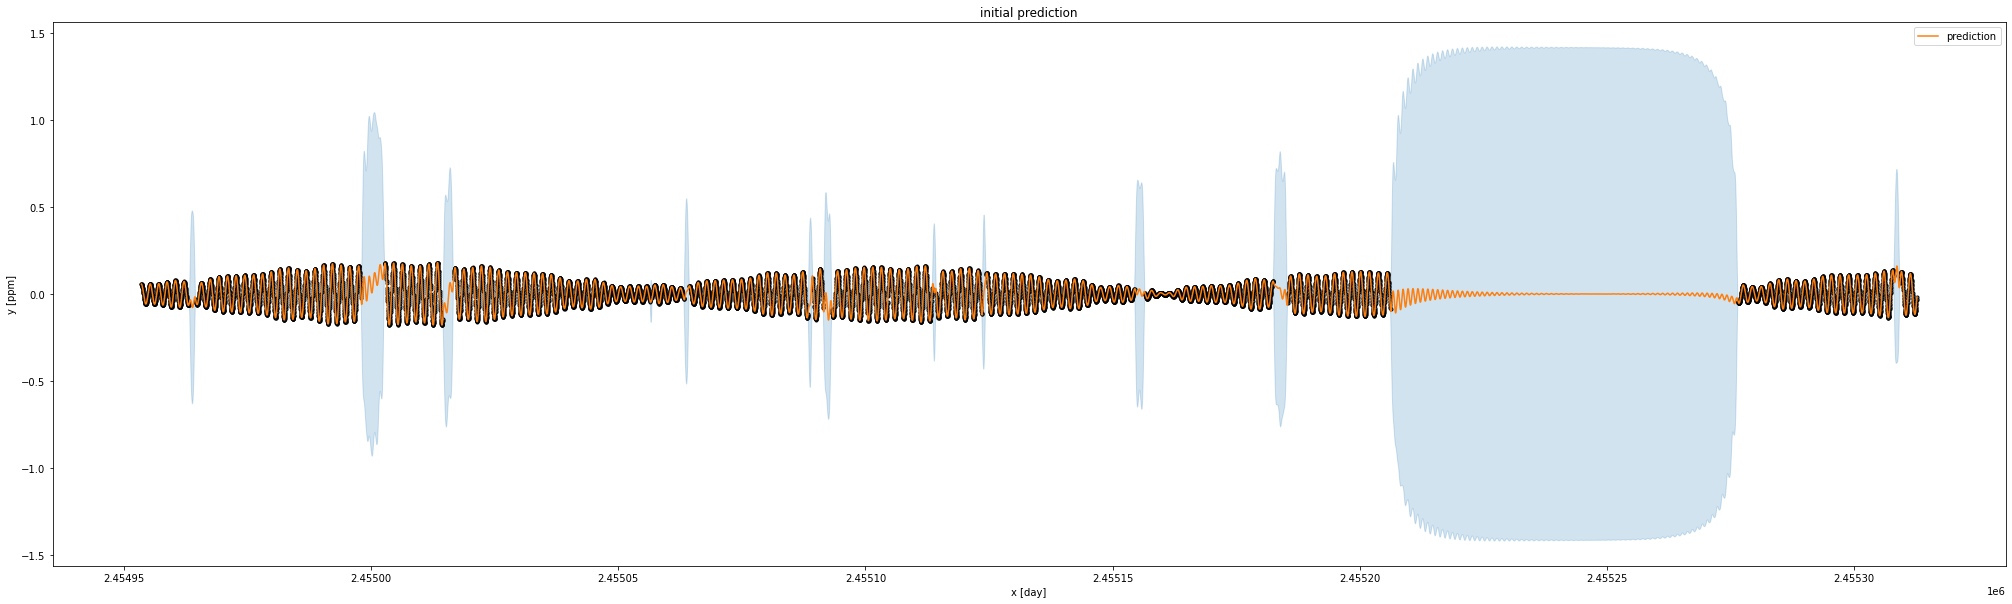

In [22]:
plt.figure(figsize=(35, 10))
plt.title("initial prediction")
plot_prediction(pred_y, variance)

In [23]:
residuals = train_y-pred_y

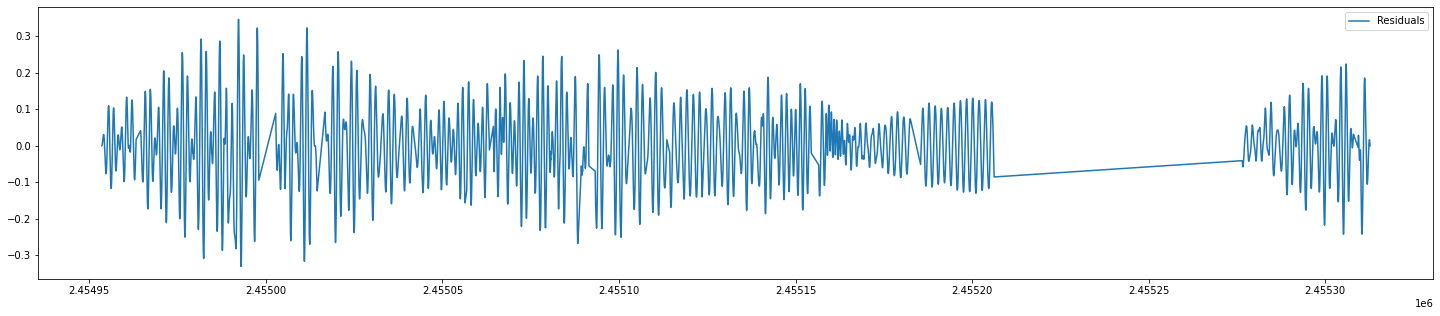

In [24]:
# Plot GP residuals
plt.figure(figsize=(25, 5))
plt.plot(train_x, residuals, "-")
plt.legend(labels=["Residuals"])

# Maximum likelihood

In [38]:
from scipy.optimize import minimize

yerr=1

def set_params(params, gp, t):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(
        sigma=theta[0], rho=theta[1], tau=theta[2]
    ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25)
    gp.compute(t, diag=yerr ** 2 + theta[5], quiet=True)
    return gp


def neg_log_like(params, gp, t, y):
    gp = set_params(params, gp, t)
    return -gp.log_likelihood(y)

# [mean, sigma1, rho1, tau1, sigma2, rho2, ]
# Q2=0.25
initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,train_x, train_y))
opt_gp = set_params(soln.x, gp, train_x)
soln

      fun: 11979.05658220092
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0003638,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 216
      nit: 25
     njev: 27
   status: 0
  success: True
        x: array([ 1.10397876e-04, -1.67939565e+01, -5.15623663e-01,  5.04831854e+00,
       -1.83444427e+01,  5.35393756e+00, -1.77546949e+01])

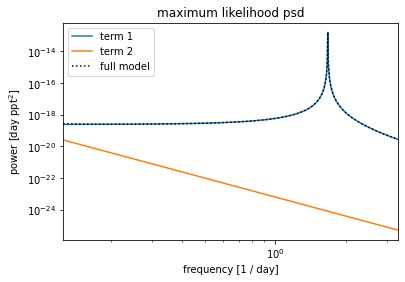

In [39]:
plt.figure()
plt.title("maximum likelihood psd")
plot_psd(opt_gp)

In [27]:
pred_y, variance = opt_gp.predict(train_y, t=test_x, return_var=True)

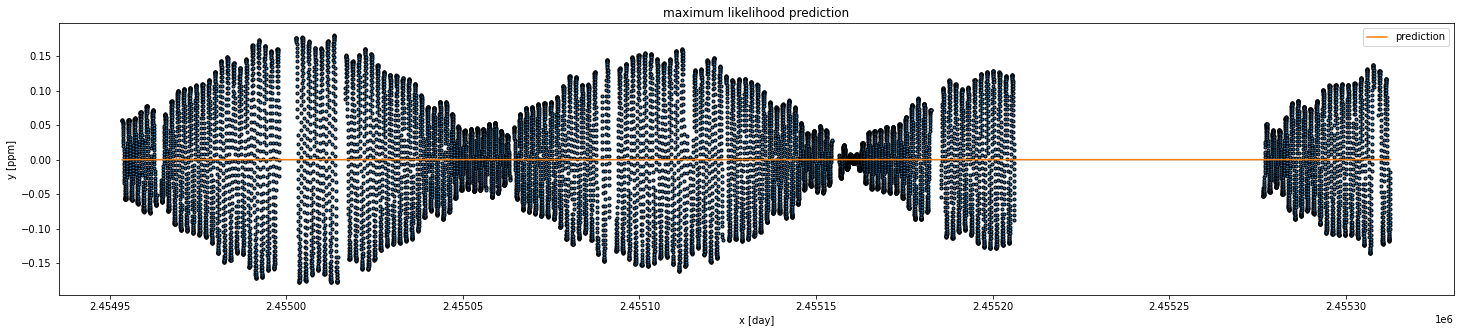

In [28]:
plt.figure(figsize=(25, 5))
plt.title("maximum likelihood prediction")
plot_prediction(pred_y, variance)

As I also saw with the GPy and GPyTorch, the longer I optimize, the worse the results will be.